# Classification de Piles par Analyse Sonore - Version Corrigée

## Corrections apportées
- **Split par PILE** (pas par fichier) pour éviter le data leakage
- **Régularisation** des modèles pour réduire l'overfitting
- **Prédiction** uniquement sur données jamais vues

## Format des données
- `C[n]_[e].wav` → Chargée
- `D[n]_[e].wav` → Déchargée  
- `P[n]_[e].wav` → Déchargée (alias)

## 1. Imports

In [1]:
import site
import sys
sys.path.append(site.getusersitepackages())

In [2]:
!{sys.executable} -m pip install --user librosa


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python3.12 -m pip install --upgrade pip


In [3]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
from pathlib import Path
from sklearn.model_selection import GroupShuffleSplit, cross_val_score, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from scipy.signal import find_peaks
import joblib
import warnings
warnings.filterwarnings('ignore')
print("Imports OK")

Imports OK


## 2. Configuration

In [4]:
DATA_DIR = "data/formatwav"
SAMPLE_RATE = None  # Utiliser le sample rate natif
DURATION = None
N_MFCC = 20
HOP_LENGTH = 512
TEST_SIZE = 0.2
RANDOM_STATE = 42
print(f"Config OK - Dossier: {DATA_DIR}")

Config OK - Dossier: data/formatwav


## 3. Fonctions

In [5]:
def parse_filename(filename):
    """
    Parse le nom du fichier.
    Formats: C1_1.wav, D4_3.wav, P11_1.wav
    """
    basename = Path(filename).stem
    match = re.match(r'^([CDP])(\d+)_(\d+)$', basename)
    if match:
        type_pile = match.group(1)
        num_pile = int(match.group(2))
        num_essai = int(match.group(3))
        label = 1 if type_pile == 'C' else 0
        # Identifiant unique de la pile (pour le groupement)
        pile_id = f"{type_pile}{num_pile}"
        return {
            'label': label,
            'type': type_pile,
            'pile': num_pile,
            'essai': num_essai,
            'pile_id': pile_id,
            'label_str': 'Chargee' if label == 1 else 'Dechargee'
        }
    return None


def extract_features(file_path):
    """
    Extrait les features spectrales d'un fichier audio.
    """
    try:
        y, sr = librosa.load(file_path, sr=SAMPLE_RATE, duration=DURATION)
        features = []
        
        # MFCC (20 coefficients x 2 stats = 40 features)
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=N_MFCC, hop_length=HOP_LENGTH)
        features.extend(np.mean(mfcc, axis=1))
        features.extend(np.std(mfcc, axis=1))
        
        # Delta MFCC (40 features)
        mfcc_delta = librosa.feature.delta(mfcc)
        features.extend(np.mean(mfcc_delta, axis=1))
        features.extend(np.std(mfcc_delta, axis=1))
        
        # Spectral Centroid (2 features)
        spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr, hop_length=HOP_LENGTH)
        features.extend([np.mean(spec_cent), np.std(spec_cent)])
        
        # Spectral Bandwidth (2 features)
        spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr, hop_length=HOP_LENGTH)
        features.extend([np.mean(spec_bw), np.std(spec_bw)])
        
        # Spectral Rolloff (2 features)
        spec_roll = librosa.feature.spectral_rolloff(y=y, sr=sr, hop_length=HOP_LENGTH)
        features.extend([np.mean(spec_roll), np.std(spec_roll)])
        
        # Spectral Contrast (7 bandes x 2 stats = 14 features)
        spec_contrast = librosa.feature.spectral_contrast(y=y, sr=sr, hop_length=HOP_LENGTH)
        features.extend(np.mean(spec_contrast, axis=1))
        features.extend(np.std(spec_contrast, axis=1))
        
        # Spectral Flatness (2 features)
        spec_flat = librosa.feature.spectral_flatness(y=y, hop_length=HOP_LENGTH)
        features.extend([np.mean(spec_flat), np.std(spec_flat)])
        
        # Zero Crossing Rate (2 features)
        zcr = librosa.feature.zero_crossing_rate(y, hop_length=HOP_LENGTH)
        features.extend([np.mean(zcr), np.std(zcr)])
        
        # RMS Energy (2 features)
        rms = librosa.feature.rms(y=y, hop_length=HOP_LENGTH)
        features.extend([np.mean(rms), np.std(rms)])
        
        # Chroma (12 notes x 2 stats = 24 features)
        chroma = librosa.feature.chroma_stft(y=y, sr=sr, hop_length=HOP_LENGTH)
        features.extend(np.mean(chroma, axis=1))
        features.extend(np.std(chroma, axis=1))
        
        # Tonnetz (6 x 2 = 12 features)
        y_harm = librosa.effects.harmonic(y)
        tonnetz = librosa.feature.tonnetz(y=y_harm, sr=sr)
        features.extend(np.mean(tonnetz, axis=1))
        features.extend(np.std(tonnetz, axis=1))
        
        # Temporal: Decay time (1 feature)
        envelope = np.abs(y)
        peak_idx = np.argmax(envelope)
        if peak_idx < len(envelope) - 1:
            decay_env = envelope[peak_idx:]
            threshold = envelope[peak_idx] * 0.1
            decay_idx = np.where(decay_env < threshold)[0]
            decay_time = decay_idx[0] / sr if len(decay_idx) > 0 else len(decay_env) / sr
        else:
            decay_time = 0
        features.append(decay_time)
        
        # Temporal: Number of peaks (1 feature)
        peaks, _ = find_peaks(envelope, height=0.1*np.max(envelope), distance=sr//100)
        features.append(len(peaks))
        
        return np.array(features)
    except Exception as e:
        print(f"Erreur: {file_path}: {e}")
        return None


def load_dataset(data_dir):
    """
    Charge tous les fichiers et extrait les features.
    Retourne aussi les groupes (pile_id) pour le split.
    """
    X, y, groups, metadata = [], [], [], []
    
    if not os.path.exists(data_dir):
        print(f"Dossier non trouve: {data_dir}")
        return np.array([]), np.array([]), np.array([]), []
    
    files = [f for f in os.listdir(data_dir) if f.lower().endswith('.wav')]
    print(f"Fichiers trouves: {len(files)}")
    
    for filename in sorted(files):
        info = parse_filename(filename)
        if info is None:
            print(f"  Format non reconnu: {filename}")
            continue
        
        features = extract_features(os.path.join(data_dir, filename))
        if features is not None:
            X.append(features)
            y.append(info['label'])
            groups.append(info['pile_id'])
            metadata.append({**info, 'filename': filename})
    
    return np.array(X), np.array(y), np.array(groups), metadata


print("Fonctions OK")

Fonctions OK


## 4. Chargement des Donnees

In [6]:
print("Chargement des donnees...\n")
X, y, groups, metadata = load_dataset(DATA_DIR)

if len(X) > 0:
    n_C = sum(1 for m in metadata if m['type'] == 'C')
    n_D = sum(1 for m in metadata if m['type'] == 'D')
    #n_P = sum(1 for m in metadata if m['type'] == 'P')
    
    unique_piles = set(groups)
    piles_C = set(g for g, m in zip(groups, metadata) if m['type'] == 'C')
    #piles_D = set(g for g, m in zip(groups, metadata) if m['type'] in ['D', 'P'])
    piles_D = set(g for g, m in zip(groups, metadata) if m['type'] == 'D')
    
    print(f"\n{'='*50}")
    print("RESUME DU DATASET")
    print(f"{'='*50}")
    print(f"Fichiers totaux: {len(X)}")
    print(f"Features par fichier: {X.shape[1]}")
    print(f"\nPar type de fichier:")
    print(f"  - Chargees (C): {n_C} fichiers")
    print(f"  - Dechargees (D): {n_D} fichiers")
    #print(f"  - Dechargees (P): {n_P} fichiers")
    print(f"\nPiles uniques:")
    print(f"  - Piles chargees: {len(piles_C)} ({sorted(piles_C)[:5]}...)")
    print(f"  - Piles dechargees: {len(piles_D)} ({sorted(piles_D)[:5]}...)")
    print(f"  - Total piles: {len(unique_piles)}")

Chargement des donnees...

Fichiers trouves: 189

RESUME DU DATASET
Fichiers totaux: 189
Features par fichier: 144

Par type de fichier:
  - Chargees (C): 93 fichiers
  - Dechargees (D): 96 fichiers

Piles uniques:
  - Piles chargees: 31 ([np.str_('C1'), np.str_('C10'), np.str_('C11'), np.str_('C12'), np.str_('C13')]...)
  - Piles dechargees: 32 ([np.str_('D1'), np.str_('D10'), np.str_('D11'), np.str_('D12'), np.str_('D13')]...)
  - Total piles: 63


## 5. Split par PILE (pas par fichier)

**Important**: On sépare les données par PILE pour éviter que la même pile soit dans train ET test (data leakage).

In [18]:
if len(X) > 0:
    print("Split par PILE (GroupShuffleSplit)...\n")
    
    # GroupShuffleSplit: garantit que tous les essais d'une pile
    # sont soit dans train, soit dans test, jamais les deux
    gss = GroupShuffleSplit(n_splits=1, test_size=TEST_SIZE, random_state=None)
    train_idx, test_idx = next(gss.split(X, y, groups))
    
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    
    # Verification: aucune pile ne doit etre dans les deux sets
    train_piles = set(groups[train_idx])
    test_piles = set(groups[test_idx])
    overlap = train_piles & test_piles
    
    print(f"{'='*50}")
    print("VERIFICATION DU SPLIT")
    print(f"{'='*50}")
    print(f"\nTRAIN:")
    print(f"  - Fichiers: {len(X_train)}")
    print(f"  - Piles: {len(train_piles)}")
    print(f"  - Chargees: {sum(y_train)} | Dechargees: {len(y_train) - sum(y_train)}")
    
    print(f"\nTEST:")
    print(f"  - Fichiers: {len(X_test)}")
    print(f"  - Piles: {len(test_piles)}")
    print(f"  - Chargees: {sum(y_test)} | Dechargees: {len(y_test) - sum(y_test)}")
    
    print(f"\nOVERLAP (piles dans train ET test):")
    if len(overlap) > 0:
        print(f"  ⚠️  ATTENTION: {len(overlap)} piles en commun: {overlap}")
        print(f"  → Data leakage detecte!")
    else:
        print(f"  ✓ Aucun overlap - Pas de data leakage")
    
    print(f"\nPiles dans TEST: {sorted(test_piles)}")
    
    # Normalisation (fit sur train, transform sur test)
    scaler = StandardScaler()
    X_train_sc = scaler.fit_transform(X_train)
    X_test_sc = scaler.transform(X_test)
    print(f"\n✓ Normalisation appliquee")

Split par PILE (GroupShuffleSplit)...

VERIFICATION DU SPLIT

TRAIN:
  - Fichiers: 150
  - Piles: 50
  - Chargees: 75 | Dechargees: 75

TEST:
  - Fichiers: 39
  - Piles: 13
  - Chargees: 18 | Dechargees: 21

OVERLAP (piles dans train ET test):
  ✓ Aucun overlap - Pas de data leakage

Piles dans TEST: [np.str_('C14'), np.str_('C17'), np.str_('C24'), np.str_('C25'), np.str_('C26'), np.str_('C7'), np.str_('D11'), np.str_('D16'), np.str_('D24'), np.str_('D25'), np.str_('D28'), np.str_('D29'), np.str_('D6')]

✓ Normalisation appliquee


## 6. Entrainement avec Regularisation

Paramètres ajustés pour réduire l'overfitting.

In [19]:
if len(X) > 0:
    # Modeles avec regularisation pour eviter l'overfitting
    models = {
        'Random Forest': RandomForestClassifier(
            n_estimators=100,
            max_depth=8,            # Reduit (etait 15)
            min_samples_leaf=5,     # Minimum 5 samples par feuille
            min_samples_split=10,   # Minimum 10 samples pour split
            random_state=RANDOM_STATE
        ),
        'Gradient Boosting': GradientBoostingClassifier(
            n_estimators=100,
            max_depth=4,            # Reduit
            min_samples_leaf=5,
            learning_rate=0.1,
            random_state=RANDOM_STATE
        ),
        'SVM (RBF)': SVC(
            kernel='rbf',
            C=1.0,                  # Reduit (etait 10)
            gamma='scale',
            probability=True,
            random_state=RANDOM_STATE
        ),
        'Neural Network': MLPClassifier(
            hidden_layer_sizes=(64, 32),  # Reduit (etait 128, 64, 32)
            max_iter=500,
            alpha=0.01,             # Regularisation L2
            early_stopping=True,
            random_state=RANDOM_STATE
        )
    }
    
    results = {}
    
    print(f"{'='*70}")
    print("ENTRAINEMENT DES MODELES (avec regularisation)")
    print(f"{'='*70}")
    print(f"\n{'Modele':<20} {'Train':>8} {'Test':>8} {'Gap':>8} {'CV (5)':>10} {'Status'}")
    print("-" * 70)
    
    for name, model in models.items():
        # Entrainement
        model.fit(X_train_sc, y_train)
        
        # Predictions
        train_acc = accuracy_score(y_train, model.predict(X_train_sc))
        test_acc = accuracy_score(y_test, model.predict(X_test_sc))
        
        # Cross-validation sur train set
        cv_scores = cross_val_score(model, X_train_sc, y_train, cv=5)
        cv_mean = cv_scores.mean()
        cv_std = cv_scores.std()
        
        # Gap train-test (indicateur d'overfitting)
        gap = train_acc - test_acc
        
        results[name] = {
            'model': model,
            'train': train_acc,
            'test': test_acc,
            'cv_mean': cv_mean,
            'cv_std': cv_std,
            'gap': gap
        }
        
        # Status: alerte si overfitting
        if gap > 0.15:
            status = "⚠️  Overfitting"
        elif gap > 0.10:
            status = "⚡ Leger overfit"
        else:
            status = "✓ OK"
        
        print(f"{name:<20} {train_acc*100:>7.1f}% {test_acc*100:>7.1f}% {gap*100:>+7.1f}% {cv_mean*100:>6.1f}%±{cv_std*100:.1f}%  {status}")
    
    # Meilleur modele base sur test accuracy
    best = max(results, key=lambda x: results[x]['test'])
    
    print(f"\n{'='*70}")
    print(f"MEILLEUR MODELE: {best}")
    print(f"  - Accuracy test: {results[best]['test']*100:.1f}%")
    print(f"  - Gap train-test: {results[best]['gap']*100:+.1f}%")
    print(f"{'='*70}")

ENTRAINEMENT DES MODELES (avec regularisation)

Modele                  Train     Test      Gap     CV (5) Status
----------------------------------------------------------------------
Random Forest           97.3%    92.3%    +5.0%   83.3%±16.6%  ✓ OK
Gradient Boosting      100.0%    92.3%    +7.7%   84.0%±13.6%  ✓ OK
SVM (RBF)               94.0%    92.3%    +1.7%   80.7%±17.0%  ✓ OK
Neural Network          90.7%    79.5%   +11.2%   80.0%±13.5%  ⚡ Leger overfit

MEILLEUR MODELE: Random Forest
  - Accuracy test: 92.3%
  - Gap train-test: +5.0%


## 7. Visualisation

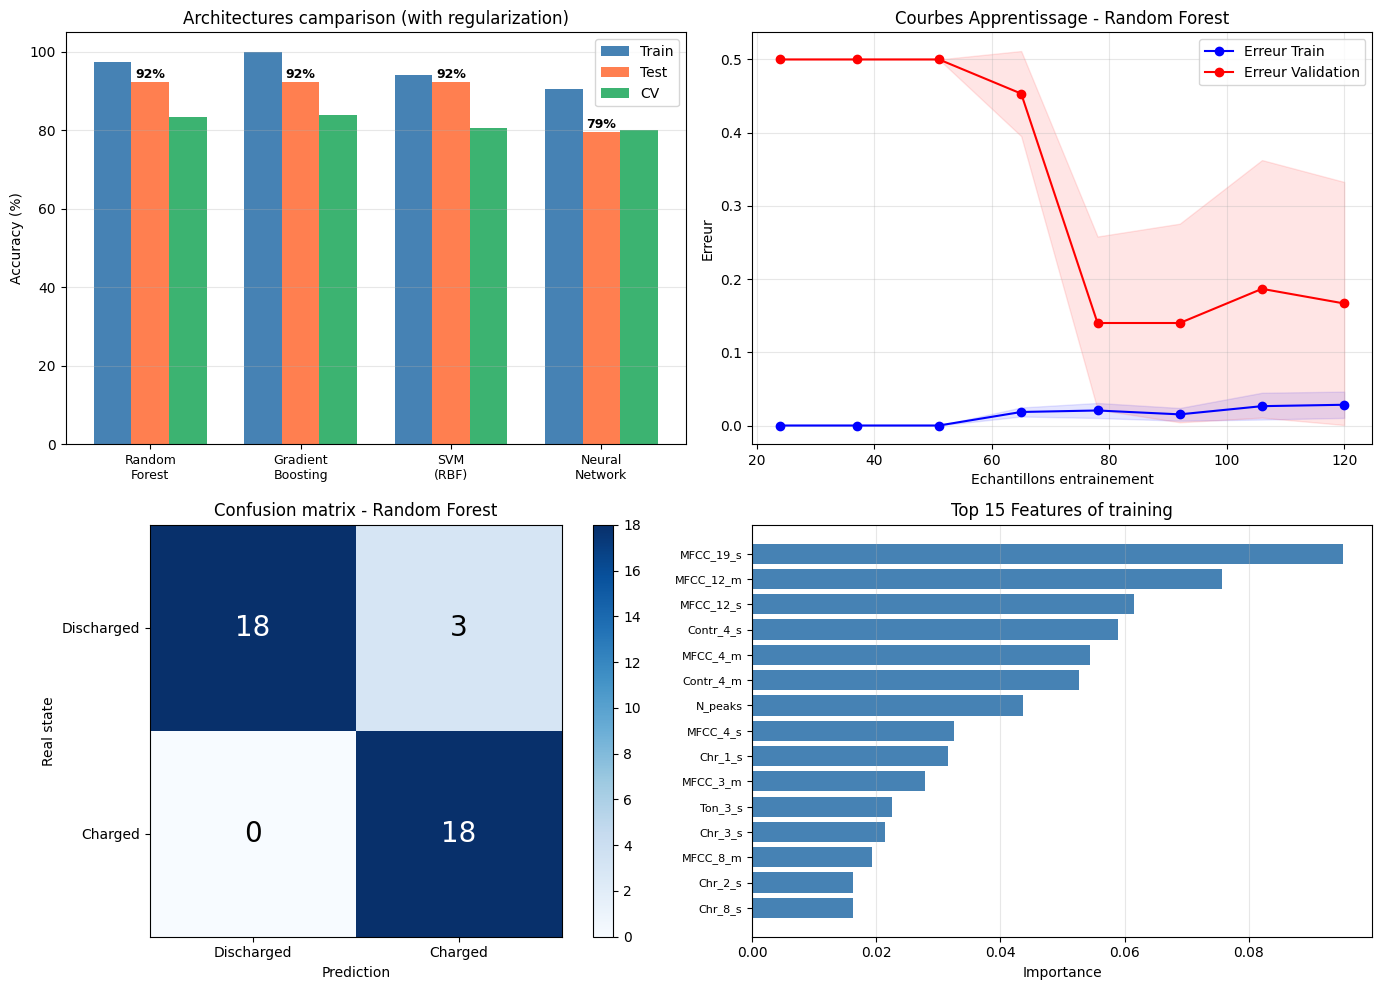


✓ Figure sauvegardee: resultats_corriges.png


In [23]:
if len(X) > 0:
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # === 1. Comparaison des modeles ===
    ax = axes[0, 0]
    names = list(results.keys())
    x = np.arange(len(names))
    width = 0.25
    
    bars1 = ax.bar(x - width, [results[n]['train']*100 for n in names], width, label='Train', color='steelblue')
    bars2 = ax.bar(x, [results[n]['test']*100 for n in names], width, label='Test', color='coral')
    bars3 = ax.bar(x + width, [results[n]['cv_mean']*100 for n in names], width, label='CV', color='mediumseagreen')
    
    ax.set_xticks(x)
    ax.set_xticklabels([n.replace(' ', '\n') for n in names], fontsize=9)
    ax.set_ylabel('Accuracy (%)')
    ax.set_title('Architectures camparison (with regularization)')
    ax.legend()
    ax.set_ylim(0, 105)
    ax.grid(axis='y', alpha=0.3)
    
    for i, n in enumerate(names):
        ax.text(i, results[n]['test']*100 + 1, f"{results[n]['test']*100:.0f}%", 
               ha='center', fontsize=9, fontweight='bold')
    
    # === 2. Learning curve ===
    ax = axes[0, 1]
    best_model = results[best]['model']
    
    train_sizes, train_scores, val_scores = learning_curve(
        best_model, X_train_sc, y_train, cv=5,
        train_sizes=np.linspace(0.2, 1.0, 8), scoring='accuracy'
    )
    
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)
    val_std = np.std(val_scores, axis=1)
    
    ax.plot(train_sizes, 1 - train_mean, 'o-', color='blue', label='Erreur Train')
    ax.fill_between(train_sizes, 1 - train_mean - train_std, 1 - train_mean + train_std, alpha=0.1, color='blue')
    ax.plot(train_sizes, 1 - val_mean, 'o-', color='red', label='Erreur Validation')
    ax.fill_between(train_sizes, 1 - val_mean - val_std, 1 - val_mean + val_std, alpha=0.1, color='red')
    
    ax.set_xlabel('Echantillons entrainement')
    ax.set_ylabel('Erreur')
    ax.set_title(f'Courbes Apprentissage - {best}')
    ax.legend()
    ax.grid(alpha=0.3)
    
    # === 3. Matrice de confusion ===
    ax = axes[1, 0]
    y_pred = best_model.predict(X_test_sc)
    cm = confusion_matrix(y_test, y_pred)
    
    im = ax.imshow(cm, cmap='Blues')
    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_xticklabels(['Discharged', 'Charged'])
    ax.set_yticklabels(['Discharged', 'Charged'])
    ax.set_xlabel('Prediction')
    ax.set_ylabel('Real state')
    ax.set_title(f'Confusion matrix - {best}')
    #ax.set_title('Confusion matrix, Real state Vs Prediction')    
    
    for i in range(2):
        for j in range(2):
            ax.text(j, i, str(cm[i, j]), ha='center', va='center',
                   color='white' if cm[i, j] > cm.max()/2 else 'black', fontsize=20)
    plt.colorbar(im, ax=ax)
    
    # === 4. Feature importance ===
    ax = axes[1, 1]
    if 'Random Forest' in results:
        rf = results['Random Forest']['model']
        imp = rf.feature_importances_
        idx = np.argsort(imp)[-15:]
        
        # Noms des features
        names_f = [f'MFCC_{i}_m' for i in range(20)] + [f'MFCC_{i}_s' for i in range(20)]
        names_f += [f'dMFCC_{i}_m' for i in range(20)] + [f'dMFCC_{i}_s' for i in range(20)]
        names_f += ['Cent_m', 'Cent_s', 'BW_m', 'BW_s', 'Roll_m', 'Roll_s']
        names_f += [f'Contr_{i}_m' for i in range(7)] + [f'Contr_{i}_s' for i in range(7)]
        names_f += ['Flat_m', 'Flat_s', 'ZCR_m', 'ZCR_s', 'RMS_m', 'RMS_s']
        names_f += [f'Chr_{i}_m' for i in range(12)] + [f'Chr_{i}_s' for i in range(12)]
        names_f += [f'Ton_{i}_m' for i in range(6)] + [f'Ton_{i}_s' for i in range(6)]
        names_f += ['Decay', 'N_peaks']
        
        ax.barh(range(15), imp[idx], color='steelblue')
        ax.set_yticks(range(15))
        ax.set_yticklabels([names_f[i] if i < len(names_f) else f'F{i}' for i in idx], fontsize=8)
        ax.set_xlabel('Importance')
        ax.set_title('Top 15 Features of training')
        ax.grid(axis='x', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('resultats_corriges.png', dpi=150)
    plt.show()
    print("\n✓ Figure sauvegardee: resultats_corriges.png")

## 8. Rapport de Classification

In [8]:
if len(X) > 0:
    print("=" * 60)
    print(f"RAPPORT DE CLASSIFICATION - {best}")
    print("=" * 60)
    
    y_pred = results[best]['model'].predict(X_test_sc)
    print(classification_report(y_test, y_pred, target_names=['Dechargee', 'Chargee']))
    
    # Resume de tous les modeles
    print("-" * 60)
    print("RESUME TOUS MODELES")
    print("-" * 60)
    print(f"{'Modele':<20} {'Train':>8} {'Test':>8} {'Gap':>8} {'Diagnostic'}")
    print("-" * 60)
    
    for name in results:
        r = results[name]
        if r['gap'] > 0.15:
            diag = "Overfitting"
        elif r['gap'] > 0.10:
            diag = "Leger overfit"
        elif r['gap'] < 0.05:
            diag = "Excellent"
        else:
            diag = "Bon"
        print(f"{name:<20} {r['train']*100:>7.1f}% {r['test']*100:>7.1f}% {r['gap']*100:>+7.1f}%  {diag}")
    
    print("\n" + "=" * 60)
    print(f"ERREUR TEST FINALE: {(1 - results[best]['test'])*100:.2f}%")
    print(f"(sur des piles JAMAIS vues pendant l'entrainement)")
    print("=" * 60)

RAPPORT DE CLASSIFICATION - Random Forest
              precision    recall  f1-score   support

   Dechargee       0.86      1.00      0.92        18
     Chargee       1.00      0.88      0.93        24

    accuracy                           0.93        42
   macro avg       0.93      0.94      0.93        42
weighted avg       0.94      0.93      0.93        42

------------------------------------------------------------
RESUME TOUS MODELES
------------------------------------------------------------
Modele                  Train     Test      Gap Diagnostic
------------------------------------------------------------
Random Forest           99.4%    92.9%    +6.6%  Bon
Gradient Boosting      100.0%    92.9%    +7.1%  Bon
SVM (RBF)               94.9%    88.1%    +6.8%  Bon
Neural Network          85.9%    81.0%    +4.9%  Excellent

ERREUR TEST FINALE: 7.14%
(sur des piles JAMAIS vues pendant l'entrainement)


## 9. Sauvegarde du Modele

In [9]:
if len(X) > 0:
    model_data = {
        'model': results[best]['model'],
        'scaler': scaler,
        'model_name': best,
        'test_accuracy': results[best]['test'],
        'train_piles': list(train_piles),
        'test_piles': list(test_piles)
    }
    
    joblib.dump(model_data, 'battery_model.joblib')
    print(f"✓ Modele sauvegarde: battery_model.joblib")
    print(f"  - Type: {best}")
    print(f"  - Accuracy test: {results[best]['test']*100:.1f}%")

✓ Modele sauvegarde: battery_model.joblib
  - Type: Random Forest
  - Accuracy test: 92.9%


## 10. Prediction sur Donnees JAMAIS Vues

Cette section teste UNIQUEMENT sur des fichiers du test set (piles jamais vues pendant l'entraînement).

In [10]:
def predict(audio_path):
    """
    Predit si une pile est chargee ou dechargee.
    """
    data = joblib.load('battery_model.joblib')
    features = extract_features(audio_path)
    if features is None:
        return None
    
    features_sc = data['scaler'].transform(features.reshape(1, -1))
    pred = data['model'].predict(features_sc)[0]
    
    proba = None
    if hasattr(data['model'], 'predict_proba'):
        proba = data['model'].predict_proba(features_sc)[0]
    
    return {
        'prediction': 'Chargee' if pred == 1 else 'Dechargee',
        'label': int(pred),
        'confidence': max(proba) if proba is not None else None
    }


# Test UNIQUEMENT sur le test set (piles jamais vues)
if os.path.exists('battery_model.joblib') and len(X) > 0:
    print("=" * 60)
    print("TEST SUR DONNEES JAMAIS VUES")
    print("(piles du test set uniquement)")
    print("=" * 60)
    
    # Recuperer les metadata du test set uniquement
    test_metadata = [metadata[i] for i in test_idx]
    
    # Selectionner quelques exemples de chaque classe
    samples_charged = [m for m in test_metadata if m['label'] == 1][:4]
    samples_discharged = [m for m in test_metadata if m['label'] == 0][:4]
    test_samples = samples_charged + samples_discharged
    
    print(f"\nTest sur {len(test_samples)} fichiers ({len(samples_charged)} C + {len(samples_discharged)} D/P):\n")
    
    n_correct = 0
    
    for m in test_samples:
        r = predict(os.path.join(DATA_DIR, m['filename']))
        if r:
            correct = (r['label'] == m['label'])
            n_correct += 1 if correct else 0
            status = '✓' if correct else '✗'
            conf = f"{r['confidence']:.1%}" if r['confidence'] else "N/A"
            print(f"  {status} {m['filename']}")
            print(f"      Pile: {m['pile_id']} (jamais vue en train)")
            print(f"      Reel: {m['label_str']} | Predit: {r['prediction']} | Conf: {conf}")
            print()
    
    print("-" * 60)
    print(f"RESULTAT: {n_correct}/{len(test_samples)} corrects ({n_correct/len(test_samples)*100:.0f}%)")
    print("=" * 60)

TEST SUR DONNEES JAMAIS VUES
(piles du test set uniquement)

Test sur 8 fichiers (4 C + 4 D/P):

  ✓ C13_1.wav
      Pile: C13 (jamais vue en train)
      Reel: Chargee | Predit: Chargee | Conf: 75.9%

  ✓ C13_2.wav
      Pile: C13 (jamais vue en train)
      Reel: Chargee | Predit: Chargee | Conf: 71.9%

  ✓ C13_3.wav
      Pile: C13 (jamais vue en train)
      Reel: Chargee | Predit: Chargee | Conf: 78.1%

  ✓ C14_1.wav
      Pile: C14 (jamais vue en train)
      Reel: Chargee | Predit: Chargee | Conf: 70.7%

  ✓ D11_1.wav
      Pile: D11 (jamais vue en train)
      Reel: Dechargee | Predit: Dechargee | Conf: 84.6%

  ✓ D11_2.wav
      Pile: D11 (jamais vue en train)
      Reel: Dechargee | Predit: Dechargee | Conf: 79.9%

  ✓ D11_3.wav
      Pile: D11 (jamais vue en train)
      Reel: Dechargee | Predit: Dechargee | Conf: 84.1%

  ✓ D1_1.wav
      Pile: D1 (jamais vue en train)
      Reel: Dechargee | Predit: Dechargee | Conf: 67.8%

-------------------------------------------------

## 11. Resume des Corrections

| Probleme | Avant | Apres |
|----------|-------|-------|
| **Data leakage** | Split par fichier | Split par **pile** (GroupShuffleSplit) |
| **Overfitting** | max_depth=15, C=10 | max_depth=8, C=1, min_samples_leaf=5 |
| **Test prediction** | Fichiers aleatoires | **Test set uniquement** |
| **Validation** | CV sur train | CV sur train ✓ |